In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_excel("./symm_groups.xlsx",index_col=0)
df = df[["Arap","Selçuk","Bizans","Ermeni"]]
df

,Arap,Selçuk,Bizans,Ermeni
p1,0.0,0.27,14.04,5.6
p1m1,0.3,0.00,9.65,0.0
p1g1,0.0,0.00,0.88,0.0
c1m1,0.0,0.55,4.39,2.4
p211,0.6,1.10,2.63,4.0
p2mm,3.9,8.79,9.65,1.6
p2mg,0.3,0.82,5.26,0.0
p2gg,0.0,0.55,0.88,6.4
c2mm,9.5,8.52,3.51,1.6
p3,0.3,0.82,0.00,0.8


# Histograms

<IPython.core.display.Javascript object>


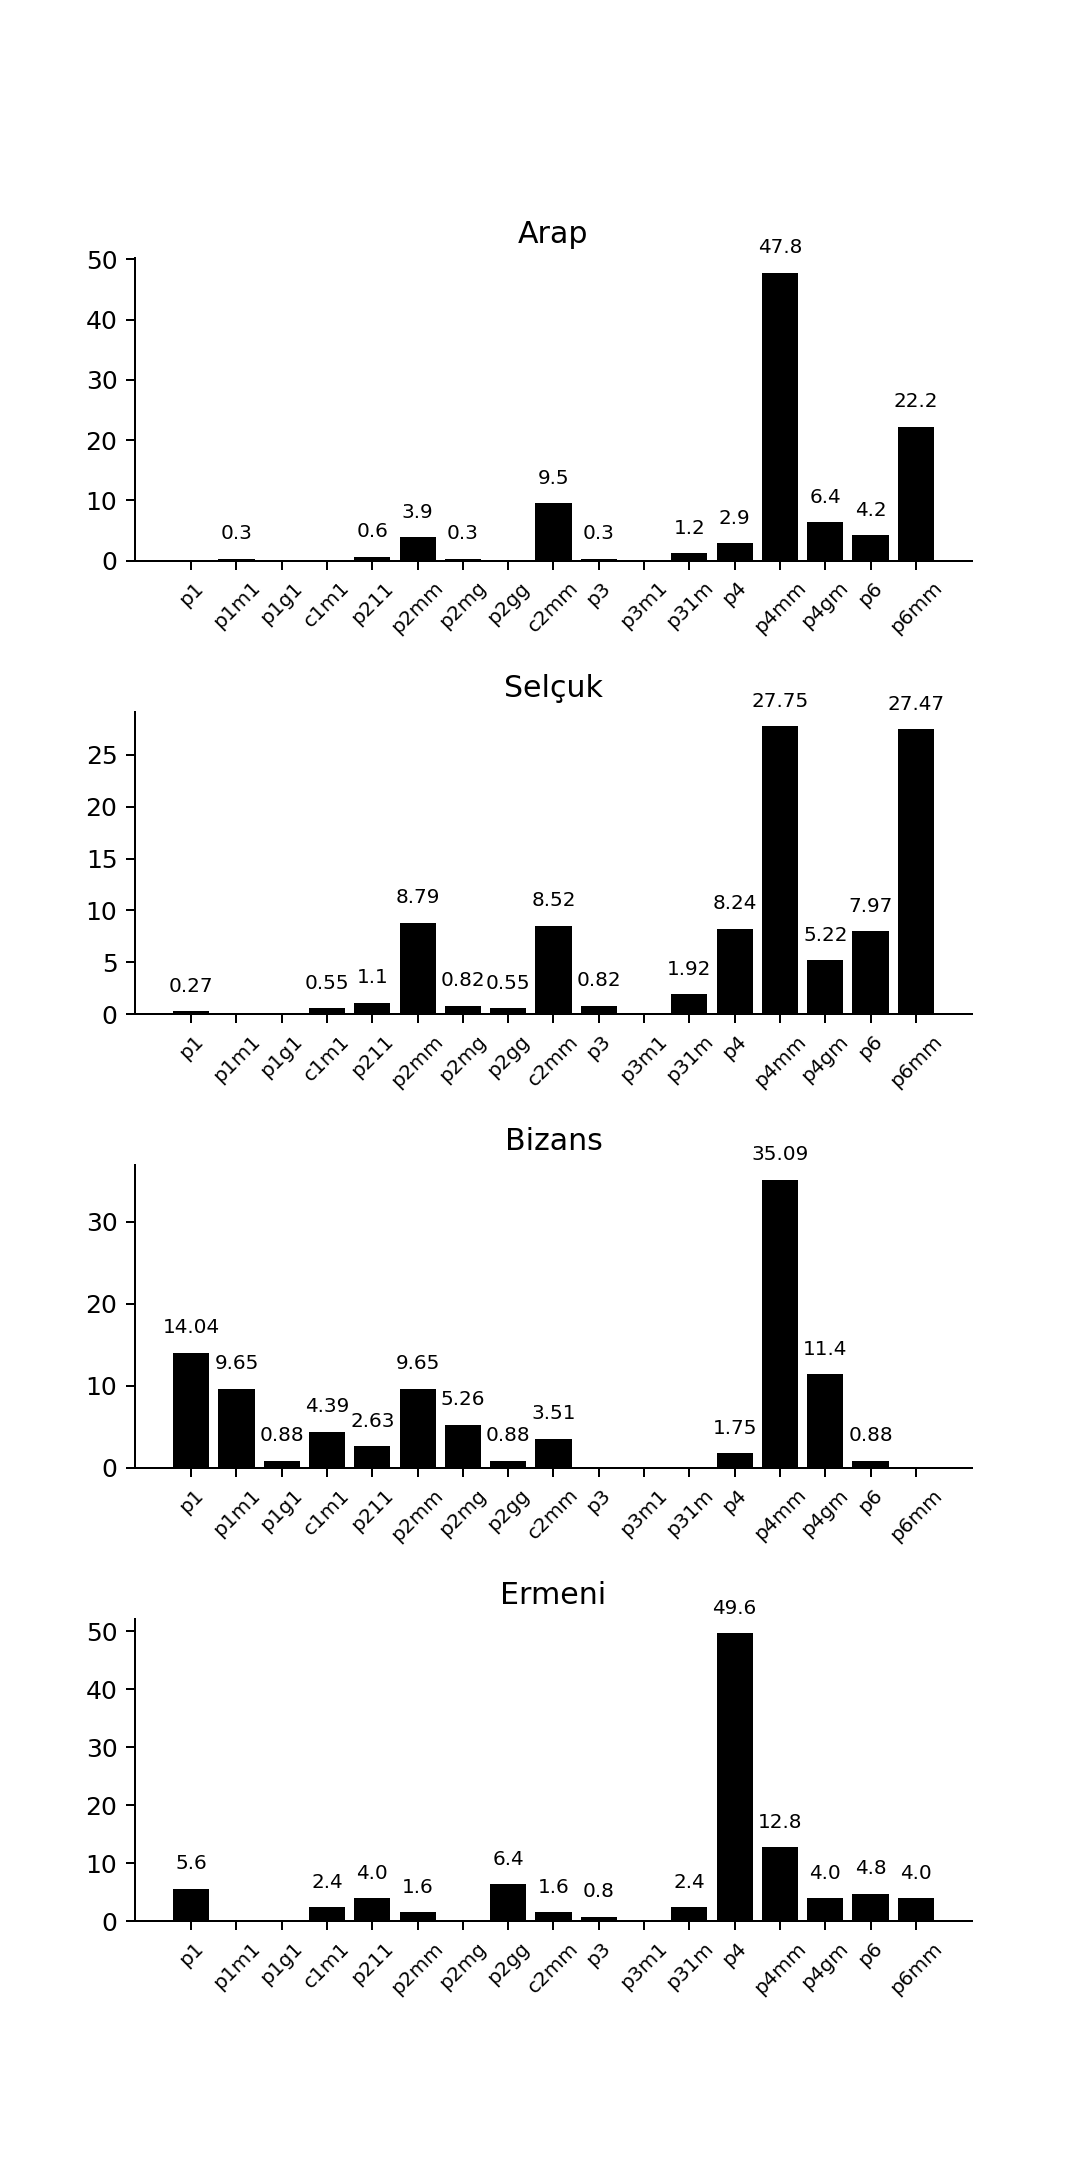

In [70]:
%matplotlib notebook
fig, ax = plt.subplots(4,1,figsize=(6,12))
cols = df.columns.to_list() 
for i in [0,1,2,3]:
    ax[i].bar(range(0,17),df[cols[i]],color='k')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xticklabels(df.index.to_list(),rotation=45,fontsize=8)
    ax[i].set_xticks(np.arange(df.shape[0]))
    for p in ax[i].patches:
        if np.ceil(p.get_height()) != 0:
            ax[i].annotate(np.round(p.get_height(),decimals=2),(p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',fontsize=8)
    ax[i].set_title(cols[i])
plt.subplots_adjust(hspace=.5)

# Correlation

<IPython.core.display.Javascript object>


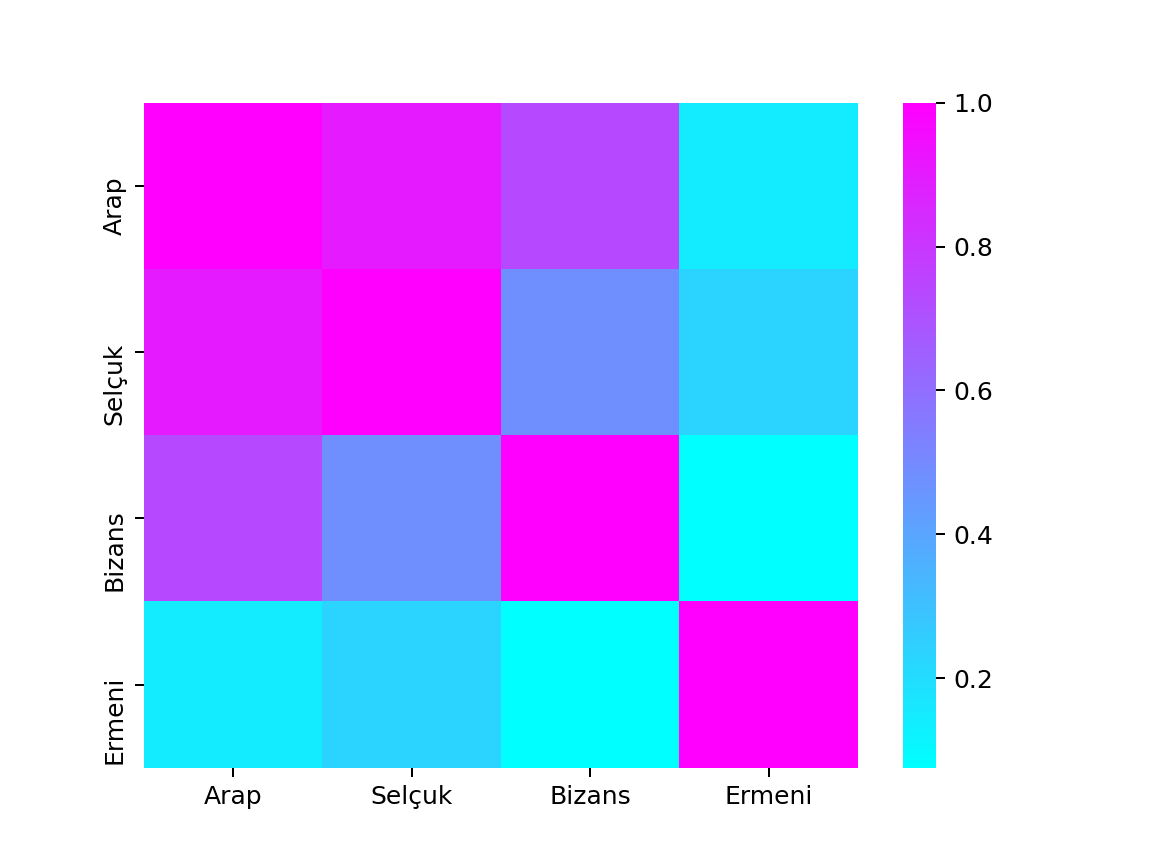

In [17]:
# calculate the correlation matrix
corr = df.corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
           cmap='cool')

#biraz deli bir renk oldu ama simdilik kalsin.

In [ ]:
# Ermeni herkesten bambaska 
# Selcuk Arap cok benziyorlar
# Bizans da Araplara epey benzemis, Ermeni'den eser yok. 